In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
import glob
import numpy as np


/agh/projects/noelia/sebastian/miniconda3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Get BRENDA sequences & propensities

In [222]:
brenda_classes = ['7.1.1.9',
 '2.7.13.3',
 '3.6.4.12',
 '7.1.1.-',
 '2.7.11.1',
 '2.7.7.6',
 '3.1.-.-',
 '2.7.7.7',
 '7.1.1.2',
 '5.2.1.8']

In [224]:
brenda = open('/agh/projects/noelia/NLP/zymCTRL/dataset_preparation/brenda_uniprot.txt', 'r')
natural_sequences = ''
for line in brenda:
    columns = line.split('\t')
    if columns[5] in brenda_classes:
        natural_sequences += columns[6].strip()
brenda.close()

In [225]:
aa_dict_natural = Counter(sequences)

In [226]:
aa_dict_natural

Counter({'M': 6951376,
         'N': 11333071,
         'D': 18797473,
         'Q': 11511122,
         'R': 19171013,
         'K': 15194416,
         'A': 33537609,
         'T': 17345292,
         'P': 14868370,
         'F': 10771511,
         'L': 31479701,
         'E': 19322693,
         'V': 24096351,
         'S': 17634256,
         'G': 25142074,
         'Y': 8263424,
         'I': 18324448,
         'W': 3003655,
         'H': 7820932,
         'C': 3722709,
         'X': 98108,
         'B': 42,
         'Z': 9})

<BarContainer object of 23 artists>

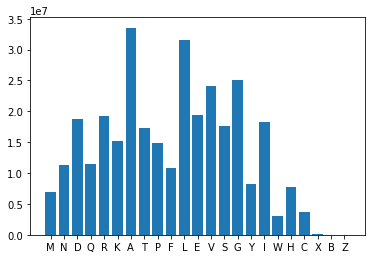

In [19]:
plt.bar(aa_dict_natural.keys(), aa_dict_natural.values())

Because these plots did not look very good, I run several top_k values (see below). Repetition penalty was also varied from 1.2 to 1.3.
I run the values using the script on  on a single GPU on scratchy.

# FINAL ANALYSIS

In [4]:
frequencies_sorted_by_type = [('X', 114348, 0,"#1f1f1f"),
                              ('B', 104,0,"#1f1f1f"),
                              ('U', 41,0, "#1f1f1f"),
                              ('Z', 34, 0,"#1f1f1f"),
                              ('O', 1,0, "#1f1f1f"),
                                            
                              ('E', 17367283,78, "#56758f"),
                              ('D', 15555581,2, "#56758f"),
                              
                              ('R', 16859901, 0,"#43aa8c"),
                              ('K', 14265001,0, "#43aa8c"),
                              ('H', 6232785, 1, "#43aa8c"),
 
                              ('F', 11072101, 0, "#91be6d"),
                              ('Y', 8329119, 0, "#91be6d"),
                              ('W', 3737133, 0, "#91be6d"),
                              
                              ('G', 19674217,0,  "#f9c751"),
                              ('P', 14337047,318,  "#f9c751"),
                              ('C', 4011055,0,  "#f9c751"),                              
                              
                              ('S', 21074983, 1, "#f9961f"),
                              ('T', 16304364,3,  "#f9961f"),
                              ('N', 11641556, 1, "#f9961f"),
                              ('Q', 10852211,0, "#f9961f"),
                             
                                                                                
                              ('L', 27264618,0, "#f94143"),
                              ('A', 24586596,236, "#f94143"),
                              ('V', 18558129, 1,"#f94143"),
                              ('I', 15554176,0, "#f94143"),
                              ('M', 6094978,1,  "#f94143"), ]

df_sorted = pd.DataFrame(frequencies_sorted_by_type, columns =["Amino acid", "Ocurrences","test1", "Color"])
print(df_sorted)

   Amino acid  Ocurrences  test1    Color
0           X      114348      0  #1f1f1f
1           B         104      0  #1f1f1f
2           U          41      0  #1f1f1f
3           Z          34      0  #1f1f1f
4           O           1      0  #1f1f1f
5           E    17367283     78  #56758f
6           D    15555581      2  #56758f
7           R    16859901      0  #43aa8c
8           K    14265001      0  #43aa8c
9           H     6232785      1  #43aa8c
10          F    11072101      0  #91be6d
11          Y     8329119      0  #91be6d
12          W     3737133      0  #91be6d
13          G    19674217      0  #f9c751
14          P    14337047    318  #f9c751
15          C     4011055      0  #f9c751
16          S    21074983      1  #f9961f
17          T    16304364      3  #f9961f
18          N    11641556      1  #f9961f
19          Q    10852211      0  #f9961f
20          L    27264618      0  #f94143
21          A    24586596    236  #f94143
22          V    18558129      1  

In [5]:
# This brenda_propensities variable was obtained in the first cells of the notebook, by looking at the propensities of the 10 largest classes.
brenda_propensities = {'M': 6951376,
                 'N': 11333071,
                 'D': 18797473,
                 'Q': 11511122,
                 'R': 19171013,
                 'K': 15194416,
                 'A': 33537609,
                 'T': 17345292,
                 'P': 14868370,
                 'F': 10771511,
                 'L': 31479701,
                 'E': 19322693,
                 'V': 24096351,
                 'S': 17634256,
                 'G': 25142074,
                 'Y': 8263424,
                 'I': 18324448,
                 'W': 3003655,
                 'H': 7820932,
                 'C': 3722709,
                 'X': 98108,
                 'B': 42,
                 'Z': 9}

topk_5 = {'L': 12269, 'A': 11252, 'G': 8880, 'E': 7337, 'S': 7046, 'R': 6999, 'V': 6821, 'P': 6282, 'I': 6150, 'T': 6064, 'D': 5619, 'K': 4976, 'F': 4018, 'N': 3462, 'Q': 3446, 'M': 2763, 'Y': 2684, 'H': 1912, 'W': 1123, 'C': 862, 'X': 2, '7': 1, '1': 1, '9': 1}
topk_6 = {'A': 11546, 'L': 10621, 'G': 8216, 'E': 7066, 'R': 6850, 'V': 6585, 'P': 6532, 'S': 6311, 'I': 5626, 'T': 5525, 'D': 5474, 'K': 4518, 'F': 3456, 'N': 3288, 'Q': 3068, 'M': 2465, 'Y': 2289, 'H': 1707, 'W': 1036, 'C': 751, 'X': 4}
topk_7 = {'L': 11685, 'A': 10915, 'G': 7880, 'E': 7425, 'V': 6937, 'S': 6916, 'R': 6796, 'I': 6311, 'P': 5993, 'T': 5821, 'D': 5632, 'K': 5042, 'F': 4496, 'N': 3898, 'Q': 3564, 'M': 2741, 'Y': 2673, 'H': 1914, 'W': 1117, 'C': 942, 'X': 70}
topk_8 = {'L': 11627, 'A': 11126, 'G': 8214, 'E': 8004, 'S': 7252, 'V': 6929, 'R': 6815, 'I': 6523, 'P': 6088, 'T': 5817, 'D': 5695, 'K': 5191, 'Q': 3977, 'F': 3956, 'N': 3808, 'M': 2800, 'Y': 2635, 'H': 2082, 'W': 1154, 'C': 944, 'X': 237}
topk_9 = {'A': 11569, 'L': 10751, 'G': 8114, 'E': 7667, 'S': 7199, 'V': 6938, 'R': 6433, 'P': 6268, 'I': 6262, 'D': 6181, 'T': 5781, 'K': 5458, 'N': 4083, 'Q': 4009, 'F': 3822, 'M': 2769, 'Y': 2708, 'H': 1885, 'W': 1019, 'C': 865, 'X': 277}
topk_10 = {'L': 10899, 'A': 10795, 'G': 8780, 'E': 7446, 'S': 7395, 'V': 7062, 'R': 6550, 'I': 6420, 'P': 5873, 'T': 5865, 'D': 5668, 'K': 5002, 'F': 4709, 'N': 3648, 'Q': 3375, 'Y': 2761, 'M': 2755, 'H': 1888, 'W': 1039, 'C': 929, 'X': 105}
topk_11 = {'L': 11325, 'A': 10635, 'G': 8235, 'E': 7598, 'V': 6887, 'S': 6812, 'R': 6360, 'I': 6141, 'T': 5905, 'P': 5695, 'D': 5544, 'K': 5049, 'F': 4055, 'N': 3577, 'Q': 3569, 'Y': 2721, 'M': 2706, 'H': 1883, 'W': 1041, 'C': 858, 'X': 32}
topk_12 = {'L': 12074, 'A': 10709, 'G': 7671, 'E': 7670, 'S': 7190, 'V': 7164, 'I': 6516, 'P': 6448, 'R': 6353, 'T': 6079, 'D': 5804, 'K': 5442, 'F': 4280, 'N': 3894, 'Q': 3364, 'Y': 2906, 'M': 2818, 'H': 2019, 'W': 1106, 'C': 897, 'X': 284}
topk_13 = {'L': 11761, 'A': 11205, 'G': 8704, 'E': 7583, 'V': 7389, 'R': 7185, 'S': 6924, 'I': 6101, 'D': 5978, 'T': 5975, 'P': 5643, 'K': 4944, 'F': 4002, 'Q': 3795, 'N': 3565, 'M': 2910, 'Y': 2805, 'H': 2029, 'W': 1141, 'C': 901, 'X': 40}
topk_14 = {'A': 12513, 'L': 10933, 'G': 8916, 'E': 7732, 'S': 7720, 'R': 7410, 'V': 7049, 'P': 6817, 'D': 5897, 'I': 5725, 'T': 5633, 'K': 5140, 'F': 3930, 'N': 3251, 'Q': 3091, 'M': 2608, 'Y': 2460, 'H': 1742, 'W': 1033, 'C': 823, 'X': 113}
topk_15 = {'L': 11285, 'A': 11189, 'G': 8670, 'E': 7791, 'S': 7242, 'V': 6841, 'R': 6785, 'I': 6530, 'P': 6433, 'D': 5736, 'T': 5511, 'K': 5246, 'F': 4854, 'N': 3668, 'Q': 3491, 'Y': 2744, 'M': 2644, 'H': 1855, 'C': 1026, 'W': 979, 'X': 323}
topk_16 = {'L': 11953, 'A': 11920, 'G': 8783, 'E': 7919, 'V': 7352, 'R': 7180, 'S': 6876, 'P': 6399, 'I': 6195, 'D': 5986, 'T': 5871, 'K': 5070, 'F': 4223, 'N': 3545, 'Q': 3527, 'M': 2826, 'Y': 2807, 'H': 1887, 'W': 1132, 'C': 928, 'X': 2}
topk_17 = {'A': 11431, 'L': 10984, 'G': 8945, 'E': 8084, 'S': 7125, 'R': 7068, 'V': 6740, 'I': 6159, 'P': 6079, 'D': 5910, 'T': 5514, 'K': 4954, 'F': 4002, 'Q': 3517, 'N': 3500, 'M': 2672, 'Y': 2660, 'H': 1956, 'W': 1049, 'C': 937, 'X': 109}
topk_18 = {'A': 12612, 'L': 11409, 'G': 8340, 'E': 8060, 'S': 7586, 'P': 7348, 'R': 6891, 'V': 6563, 'I': 6325, 'T': 6279, 'D': 5677, 'K': 4989, 'F': 4041, 'Q': 3605, 'N': 3404, 'M': 2843, 'Y': 2751, 'H': 2008, 'W': 1121, 'C': 951, 'X': 9}
topk_19 = {'L': 11642, 'A': 11287, 'G': 8238, 'E': 8000, 'V': 7407, 'S': 7378, 'R': 7114, 'I': 6368, 'T': 6323, 'P': 6026, 'D': 5922, 'K': 5437, 'Q': 4122, 'F': 4114, 'N': 3572, 'M': 2971, 'Y': 2792, 'H': 2107, 'W': 1104, 'C': 1003, 'X': 5}
topk_20 = {'L': 10955, 'A': 10695, 'E': 8099, 'G': 7909, 'V': 7064, 'S': 6744, 'R': 6575, 'I': 6163, 'P': 5859, 'D': 5696, 'T': 5619, 'K': 5288, 'F': 3846, 'Q': 3566, 'N': 3446, 'M': 2727, 'Y': 2599, 'H': 1827, 'W': 1009, 'C': 829, 'X': 36}
topk_30 = {'L': 11261, 'A': 10939, 'G': 8246, 'E': 7101, 'V': 6942, 'S': 6723, 'R': 6632, 'I': 6135, 'P': 5867, 'T': 5656, 'D': 5560, 'K': 4790, 'F': 3945, 'N': 3287, 'Q': 3285, 'M': 2628, 'Y': 2581, 'H': 1843, 'W': 1094, 'C': 926, 'X': 6}
topk_50 = {'A': 12119, 'L': 11791, 'G': 8995, 'E': 7558, 'S': 7490, 'V': 7102, 'R': 6964, 'P': 6420, 'T': 6390, 'I': 6262, 'D': 5776, 'K': 5202, 'F': 3856, 'N': 3457, 'Q': 3238, 'M': 2721, 'Y': 2587, 'H': 1776, 'W': 1165, 'C': 815, 'X': 143}
topk_100 = {'L': 11495, 'A': 11117, 'G': 8350, 'S': 7691, 'E': 7643, 'V': 7122, 'R': 6884, 'I': 6496, 'D': 6311, 'P': 6026, 'T': 5983, 'K': 5638, 'N': 4127, 'F': 3976, 'Q': 3619, 'Y': 2818, 'M': 2743, 'H': 2029, 'W': 1083, 'C': 872, 'X': 439}
topk_200 = {'L': 11529, 'A': 10763, 'G': 8502, 'E': 8005, 'S': 7148, 'V': 7130, 'R': 6994, 'P': 6323, 'I': 6218, 'T': 5986, 'D': 5877, 'K': 5573, 'F': 3789, 'N': 3700, 'Q': 3637, 'M': 2783, 'Y': 2641, 'H': 1957, 'W': 972, 'C': 953, 'X': 14}
topk_458 =  {'A': 11545, 'L': 11489, 'G': 8748, 'E': 7722, 'R': 7180, 'V': 7141, 'S': 6832, 'P': 6350, 'I': 6072, 'D': 5701, 'T': 5689, 'K': 4688, 'F': 3929, 'Q': 3488, 'N': 3274, 'Y': 2740, 'M': 2696, 'H': 1910, 'W': 1127, 'C': 807, 'X': 36}

# this list had 1 charater '-', which I removed.

# with the right order: 
brenda = [brenda_propensities[x[0]] if (x[0] in brenda_propensities) else 0 for x in frequencies_sorted_by_type]
test5 = [topk_5[x[0]] if (x[0] in topk_5) else 0 for x in frequencies_sorted_by_type]
test6 = [topk_6[x[0]] if (x[0] in topk_6) else 0 for x in frequencies_sorted_by_type]
test7 = [topk_7[x[0]] if (x[0] in topk_7) else 0 for x in frequencies_sorted_by_type]
test8 = [topk_8[x[0]] if (x[0] in topk_8) else 0 for x in frequencies_sorted_by_type]

test9 = [topk_9[x[0]] if (x[0] in topk_9) else 0 for x in frequencies_sorted_by_type]
test10 = [topk_10[x[0]] if (x[0] in topk_10) else 0 for x in frequencies_sorted_by_type]
test11 = [topk_11[x[0]] if (x[0] in topk_11) else 0 for x in frequencies_sorted_by_type]
test12 = [topk_12[x[0]] if (x[0] in topk_12) else 0 for x in frequencies_sorted_by_type]

test13 = [topk_13[x[0]] if (x[0] in topk_13) else 0 for x in frequencies_sorted_by_type]
test14 = [topk_14[x[0]] if (x[0] in topk_14) else 0 for x in frequencies_sorted_by_type]
test15 = [topk_15[x[0]] if (x[0] in topk_15) else 0 for x in frequencies_sorted_by_type]
test16 = [topk_16[x[0]] if (x[0] in topk_16) else 0 for x in frequencies_sorted_by_type]

test17 = [topk_17[x[0]] if (x[0] in topk_17) else 0 for x in frequencies_sorted_by_type]
test18 = [topk_18[x[0]] if (x[0] in topk_18) else 0 for x in frequencies_sorted_by_type]
test19 = [topk_19[x[0]] if (x[0] in topk_19) else 0 for x in frequencies_sorted_by_type]
test20 = [topk_20[x[0]] if (x[0] in topk_20) else 0 for x in frequencies_sorted_by_type]

test30 = [topk_30[x[0]] if (x[0] in topk_30) else 0 for x in frequencies_sorted_by_type]
test50 = [topk_50[x[0]] if (x[0] in topk_50) else 0 for x in frequencies_sorted_by_type]
test100 = [topk_100[x[0]] if (x[0] in topk_100) else 0 for x in frequencies_sorted_by_type]
test200 = [topk_200[x[0]] if (x[0] in topk_200) else 0 for x in frequencies_sorted_by_type]
test458 = [topk_458[x[0]] if (x[0] in topk_458) else 0 for x in frequencies_sorted_by_type]


df_sorted['Ocurrences'] = brenda
df_sorted['test5'] = test5
df_sorted['test6'] = test6
df_sorted['test7'] = test7
df_sorted['test8'] = test8
df_sorted['test9'] = test9
df_sorted['test10'] = test10
df_sorted['test11'] = test11
df_sorted['test12'] = test12
df_sorted['test13'] = test13
df_sorted['test14'] = test14
df_sorted['test15'] = test15

df_sorted['test16'] = test16
df_sorted['test17'] = test17
df_sorted['test18'] = test18
df_sorted['test19'] = test19
df_sorted['test20'] = test20

df_sorted['test30'] = test30
df_sorted['test50'] = test50
df_sorted['test100'] = test100
df_sorted['test200'] = test200
df_sorted['test458'] = test458

normalized_df=df_sorted.copy()

normalized_df["Ocurrences"]=(df_sorted["Ocurrences"]-df_sorted["Ocurrences"].min())/(df_sorted["Ocurrences"].max()-df_sorted["Ocurrences"].min())
normalized_df["test5"]=(df_sorted["test5"]-df_sorted["test5"].min())/(df_sorted["test5"].max()-df_sorted["test5"].min())
normalized_df["test6"]=(df_sorted["test6"]-df_sorted["test6"].min())/(df_sorted["test6"].max()-df_sorted["test6"].min())
normalized_df["test7"]=(df_sorted["test7"]-df_sorted["test7"].min())/(df_sorted["test7"].max()-df_sorted["test7"].min())
normalized_df["test8"]=(df_sorted["test8"]-df_sorted["test8"].min())/(df_sorted["test8"].max()-df_sorted["test8"].min())
normalized_df["test9"]=(df_sorted["test9"]-df_sorted["test9"].min())/(df_sorted["test9"].max()-df_sorted["test9"].min())
normalized_df["test10"]=(df_sorted["test10"]-df_sorted["test10"].min())/(df_sorted["test10"].max()-df_sorted["test10"].min())

normalized_df["test11"]=(df_sorted["test11"]-df_sorted["test11"].min())/(df_sorted["test11"].max()-df_sorted["test11"].min())
normalized_df["test12"]=(df_sorted["test12"]-df_sorted["test12"].min())/(df_sorted["test12"].max()-df_sorted["test12"].min())
normalized_df["test13"]=(df_sorted["test13"]-df_sorted["test13"].min())/(df_sorted["test13"].max()-df_sorted["test13"].min())
normalized_df["test14"]=(df_sorted["test14"]-df_sorted["test14"].min())/(df_sorted["test14"].max()-df_sorted["test14"].min())
normalized_df["test15"]=(df_sorted["test15"]-df_sorted["test15"].min())/(df_sorted["test15"].max()-df_sorted["test15"].min())
normalized_df["test16"]=(df_sorted["test16"]-df_sorted["test16"].min())/(df_sorted["test16"].max()-df_sorted["test16"].min())

normalized_df["test17"]=(df_sorted["test17"]-df_sorted["test17"].min())/(df_sorted["test17"].max()-df_sorted["test17"].min())
normalized_df["test18"]=(df_sorted["test18"]-df_sorted["test18"].min())/(df_sorted["test18"].max()-df_sorted["test18"].min())
normalized_df["test19"]=(df_sorted["test19"]-df_sorted["test19"].min())/(df_sorted["test19"].max()-df_sorted["test19"].min())
normalized_df["test20"]=(df_sorted["test20"]-df_sorted["test20"].min())/(df_sorted["test20"].max()-df_sorted["test20"].min())

normalized_df["test30"]=(df_sorted["test30"]-df_sorted["test30"].min())/(df_sorted["test30"].max()-df_sorted["test30"].min())
normalized_df["test50"]=(df_sorted["test50"]-df_sorted["test50"].min())/(df_sorted["test50"].max()-df_sorted["test50"].min())
normalized_df["test100"]=(df_sorted["test100"]-df_sorted["test100"].min())/(df_sorted["test100"].max()-df_sorted["test100"].min())
normalized_df["test200"]=(df_sorted["test200"]-df_sorted["test200"].min())/(df_sorted["test200"].max()-df_sorted["test200"].min())
normalized_df["test458"]=(df_sorted["test458"]-df_sorted["test458"].min())/(df_sorted["test458"].max()-df_sorted["test458"].min())


### TOP_K 6

Plotting TEST: test5
Plotting TEST: test6
Plotting TEST: test7
Plotting TEST: test8
Plotting TEST: test9
Plotting TEST: test10
Plotting TEST: test11
Plotting TEST: test12
Plotting TEST: test13
Plotting TEST: test14
Plotting TEST: test15
Plotting TEST: test16
Plotting TEST: test17
Plotting TEST: test18
Plotting TEST: test19
Plotting TEST: test20
Plotting TEST: test30
Plotting TEST: test50
Plotting TEST: test100
Plotting TEST: test200
Plotting TEST: test458


/agh/projects/noelia/sebastian/miniconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


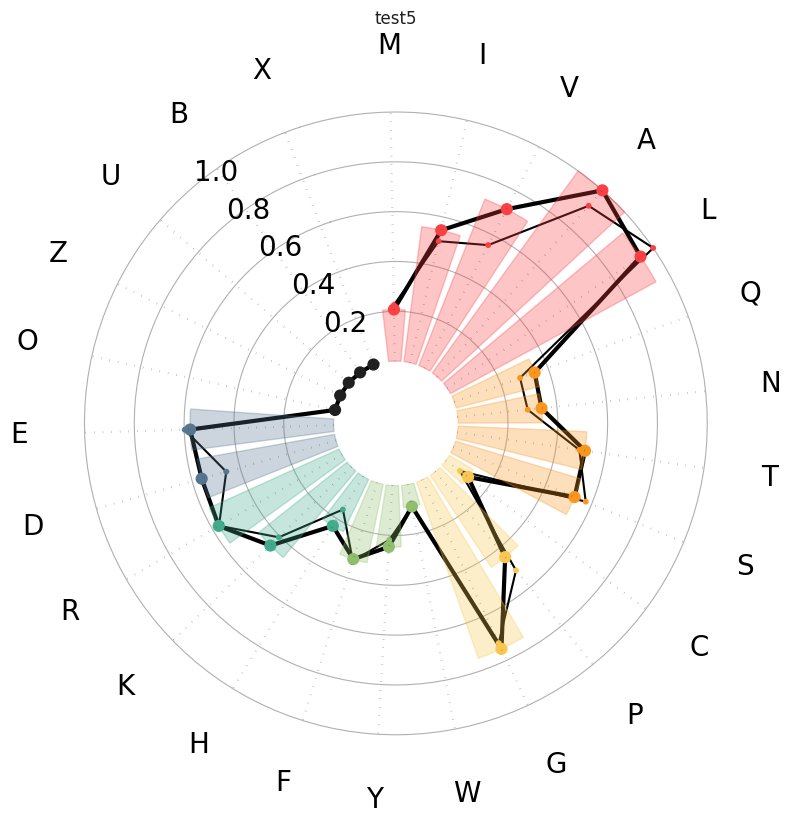

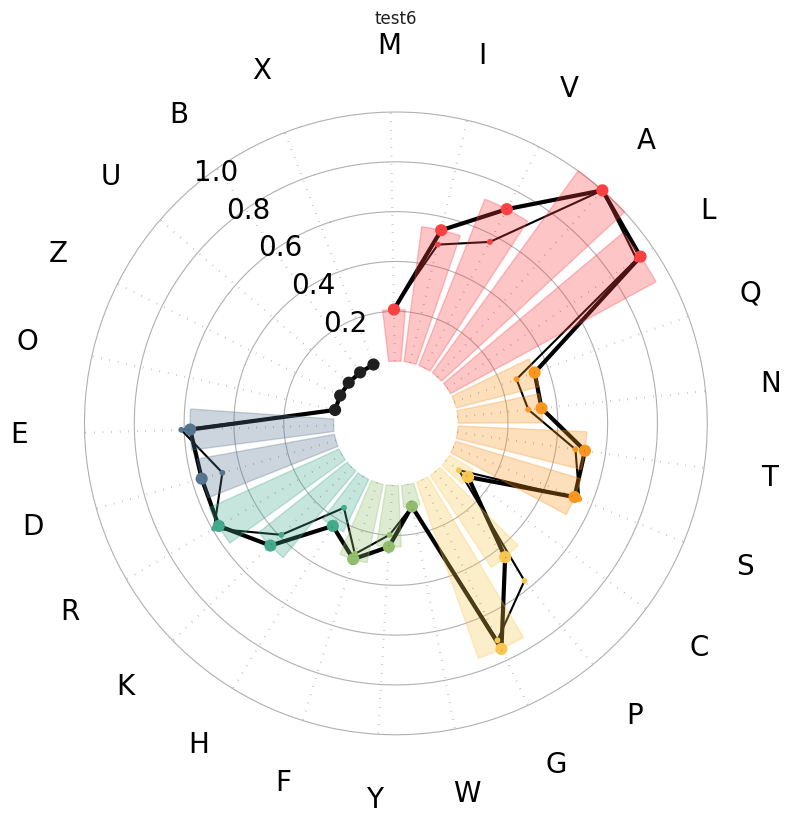

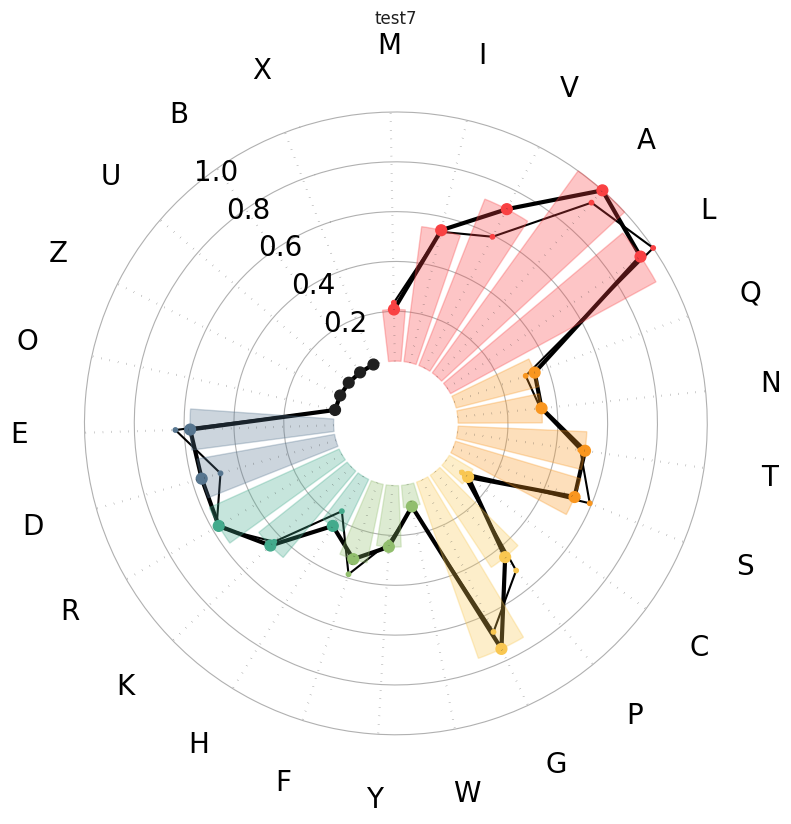

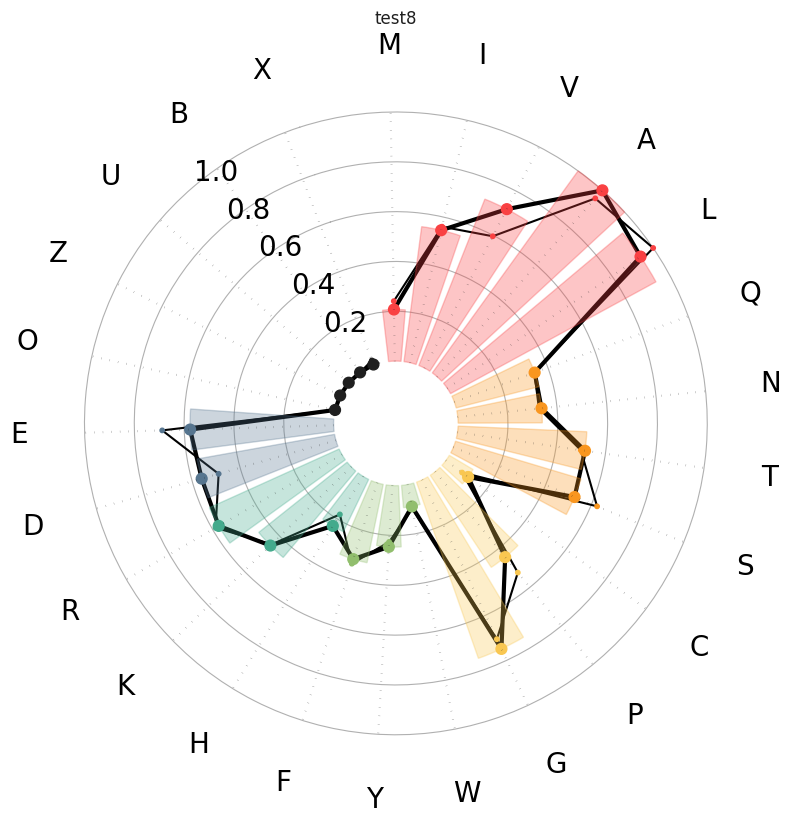

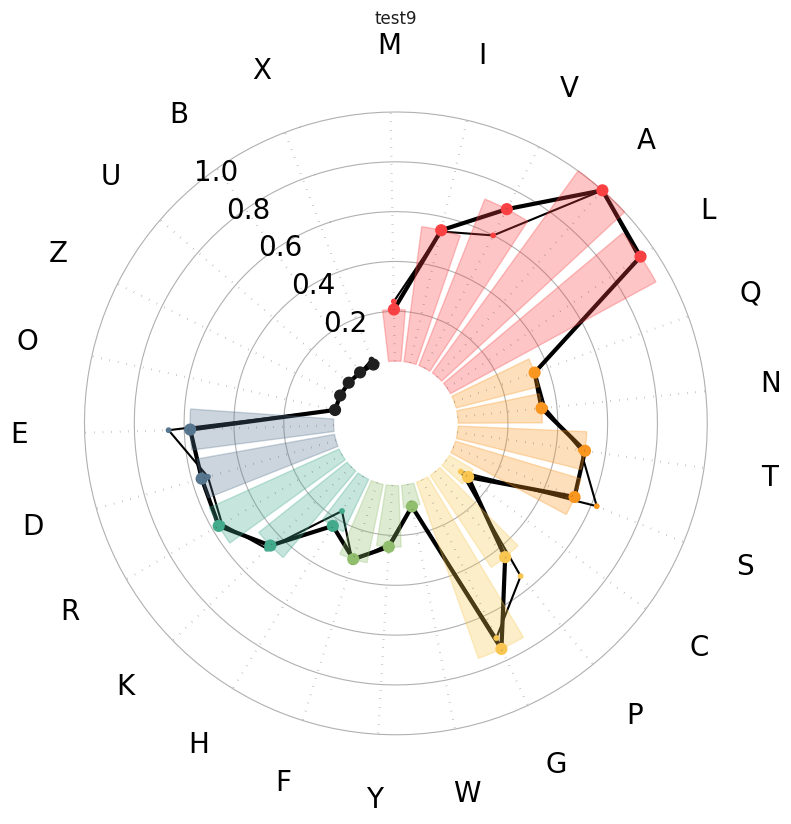

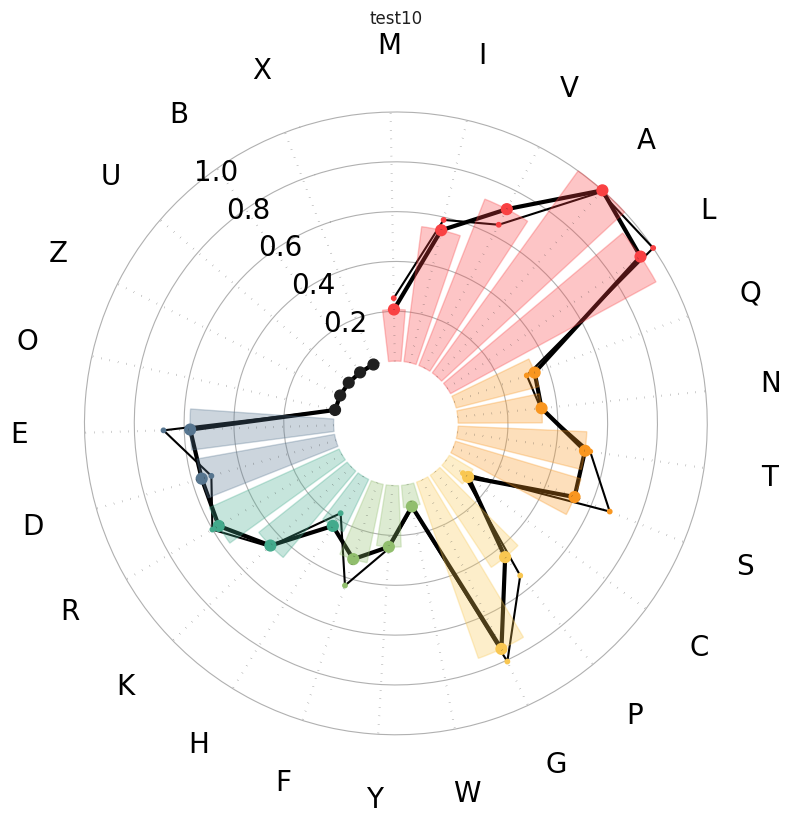

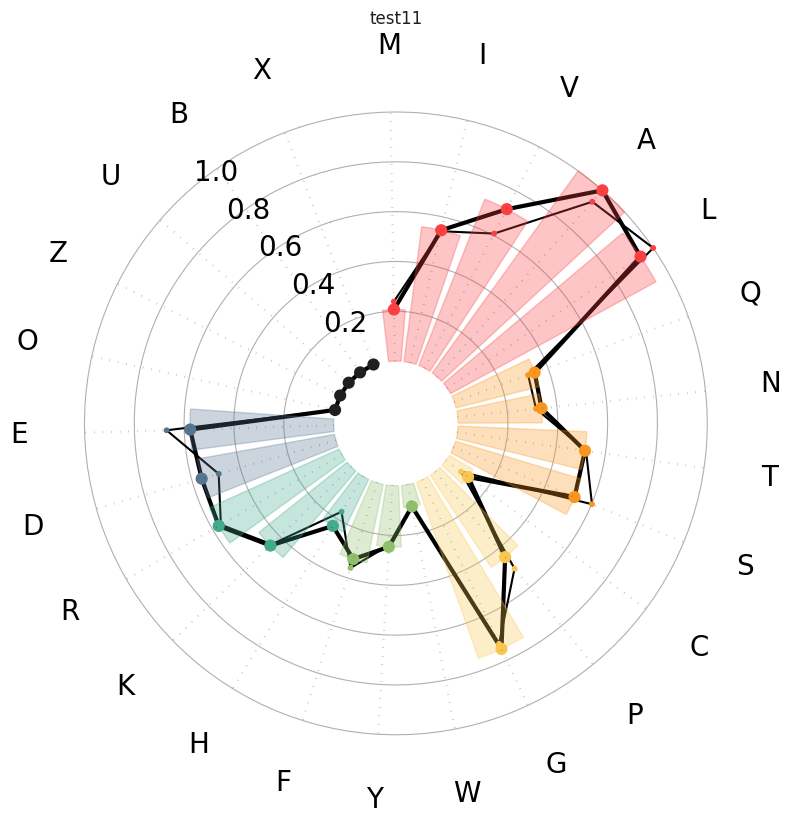

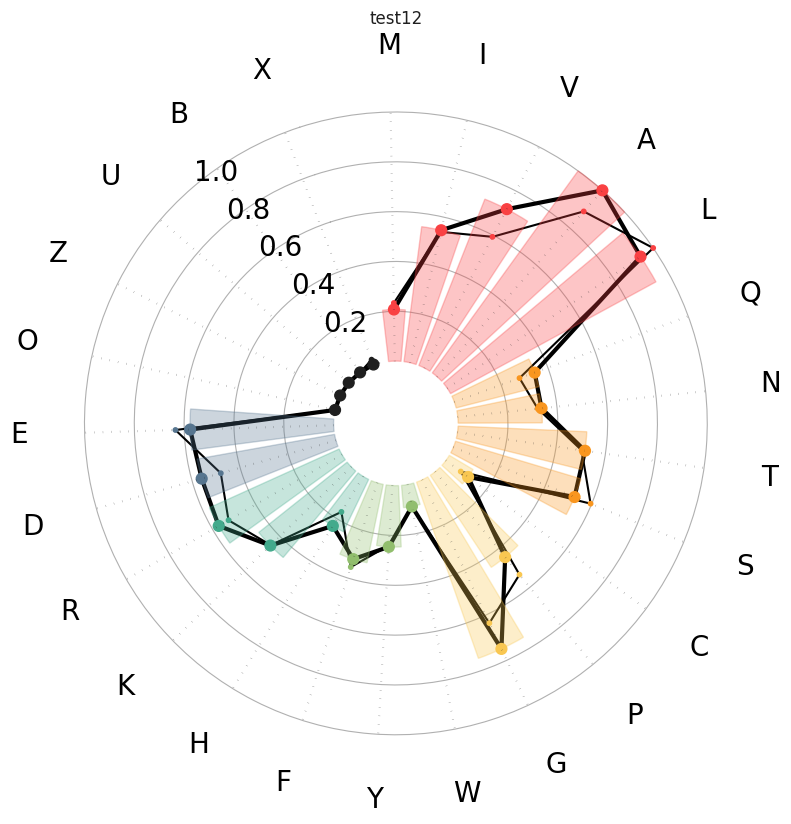

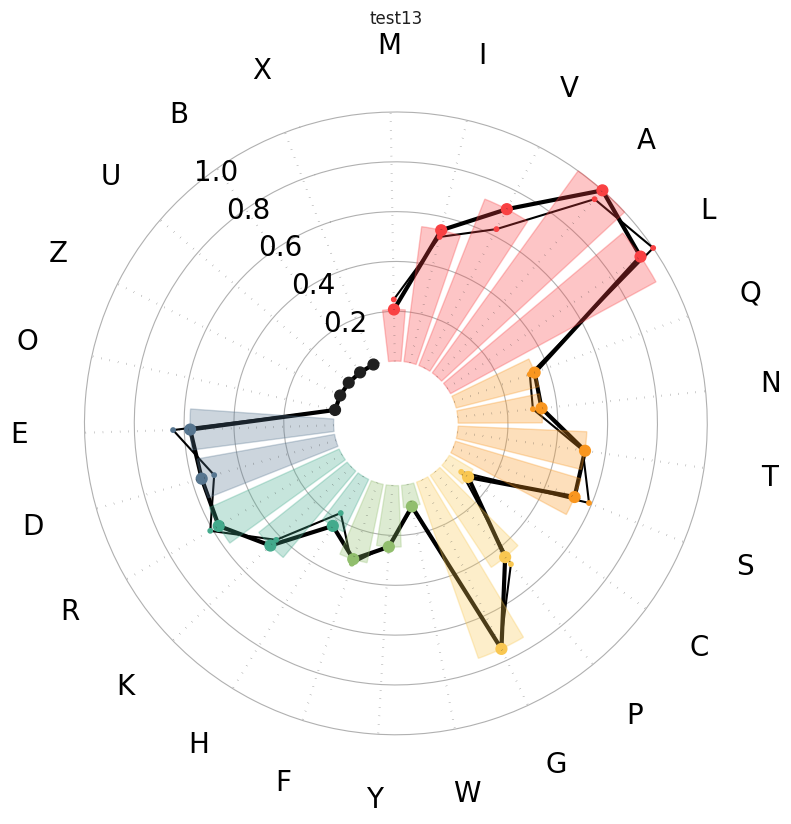

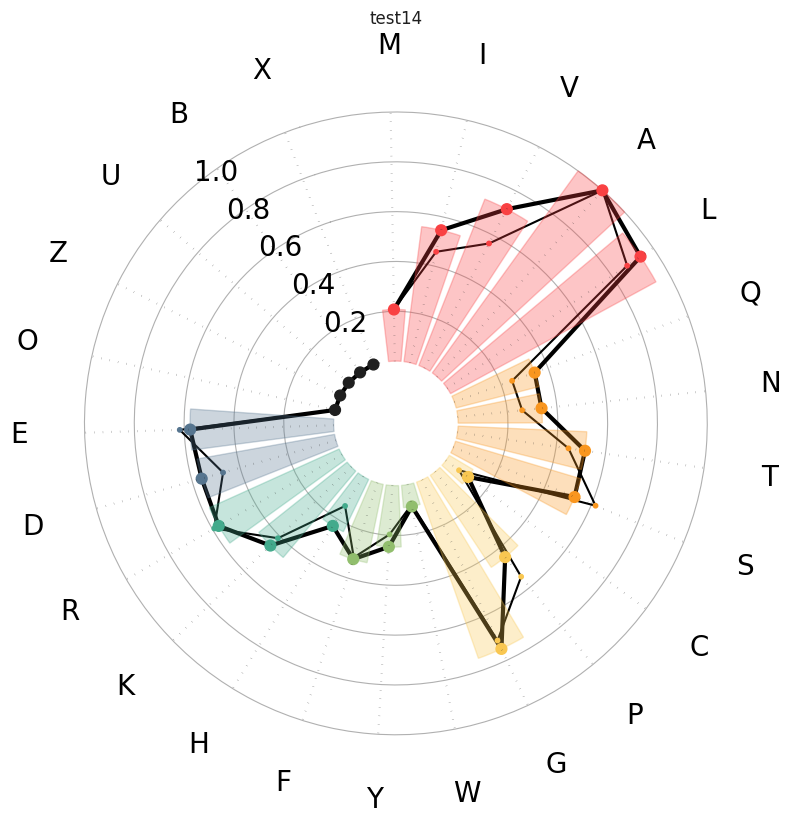

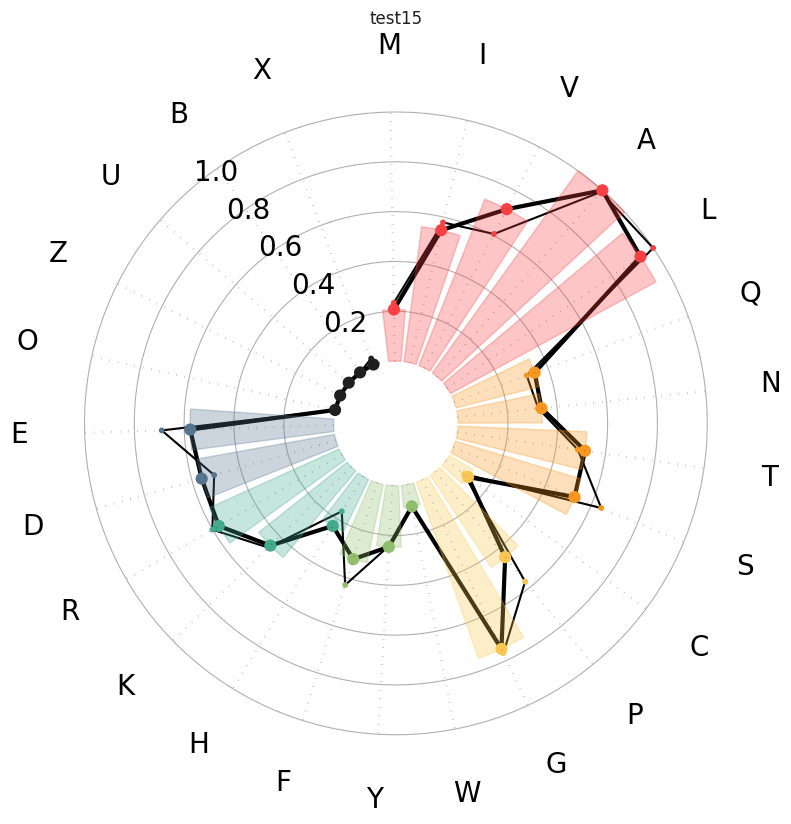

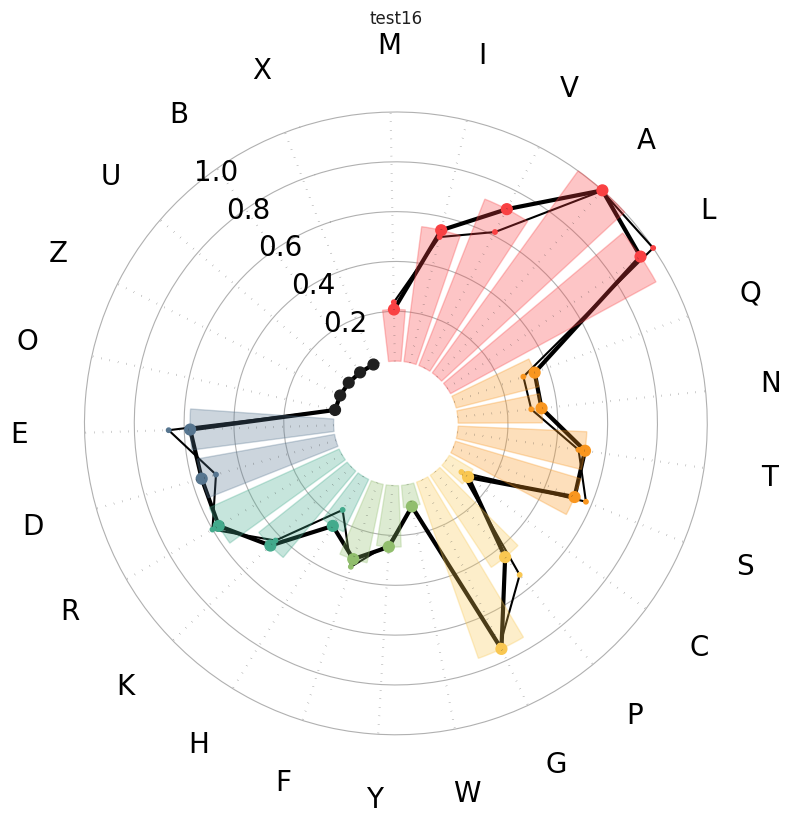

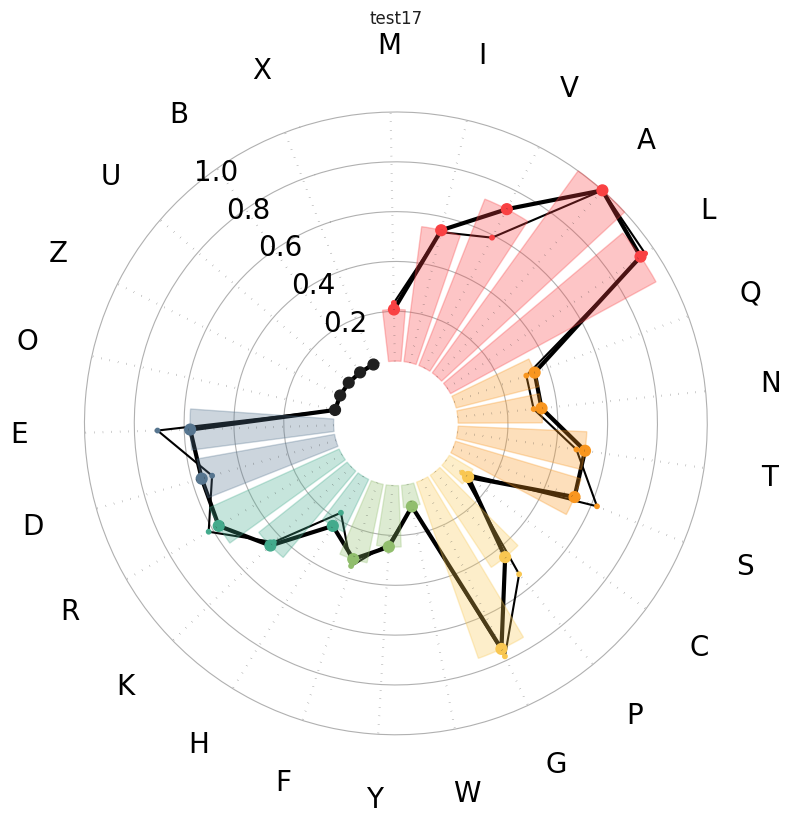

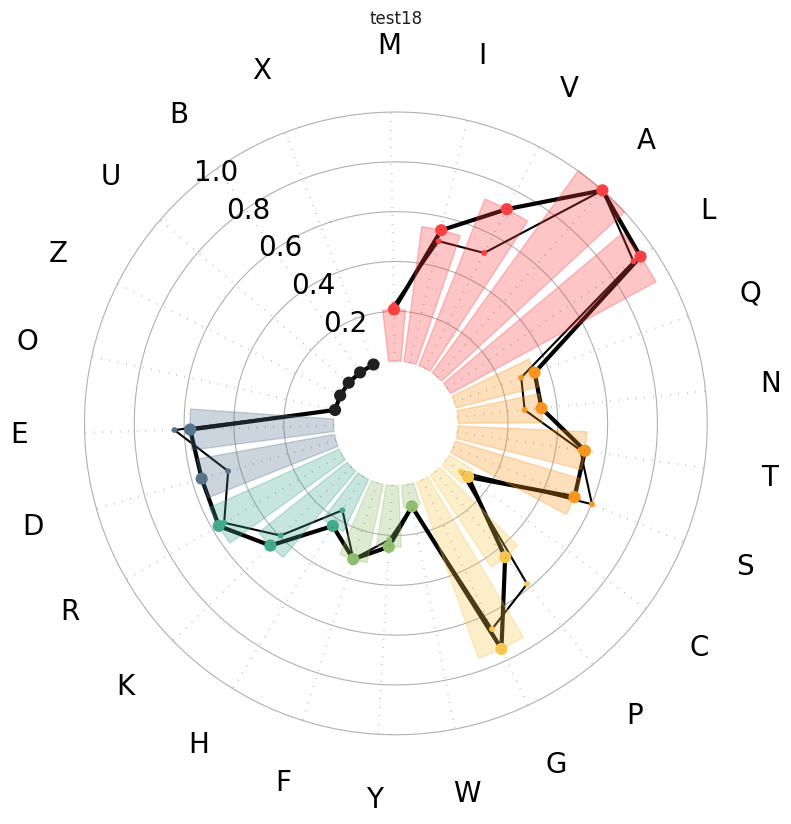

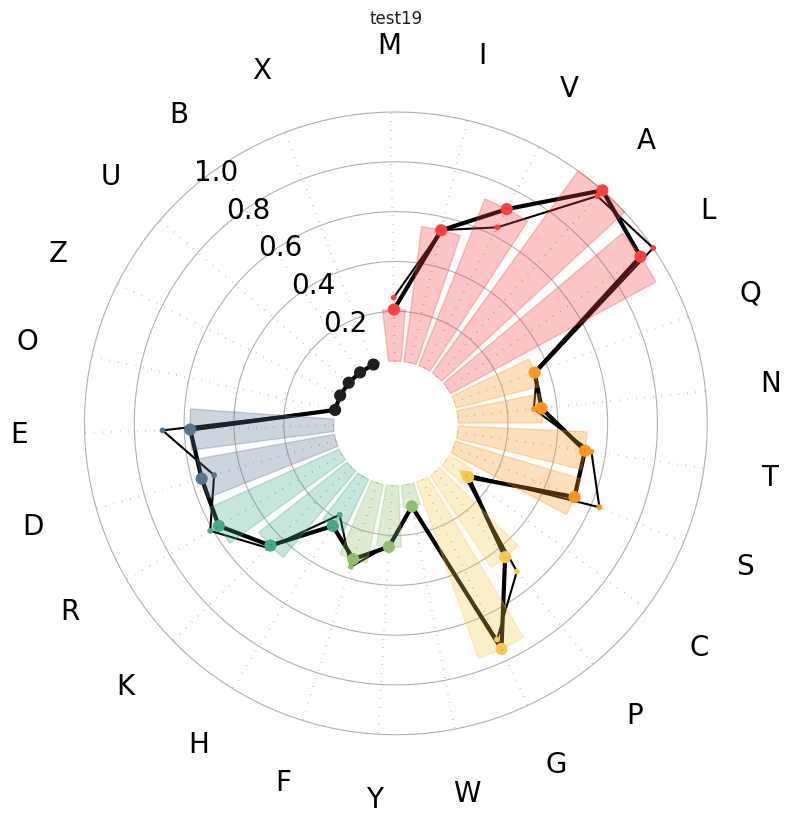

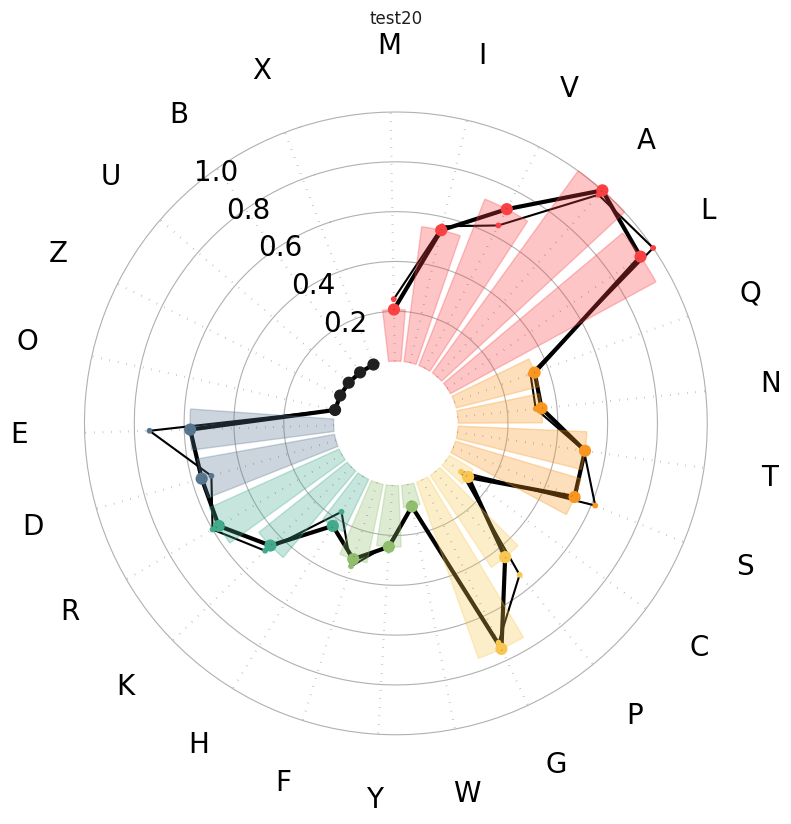

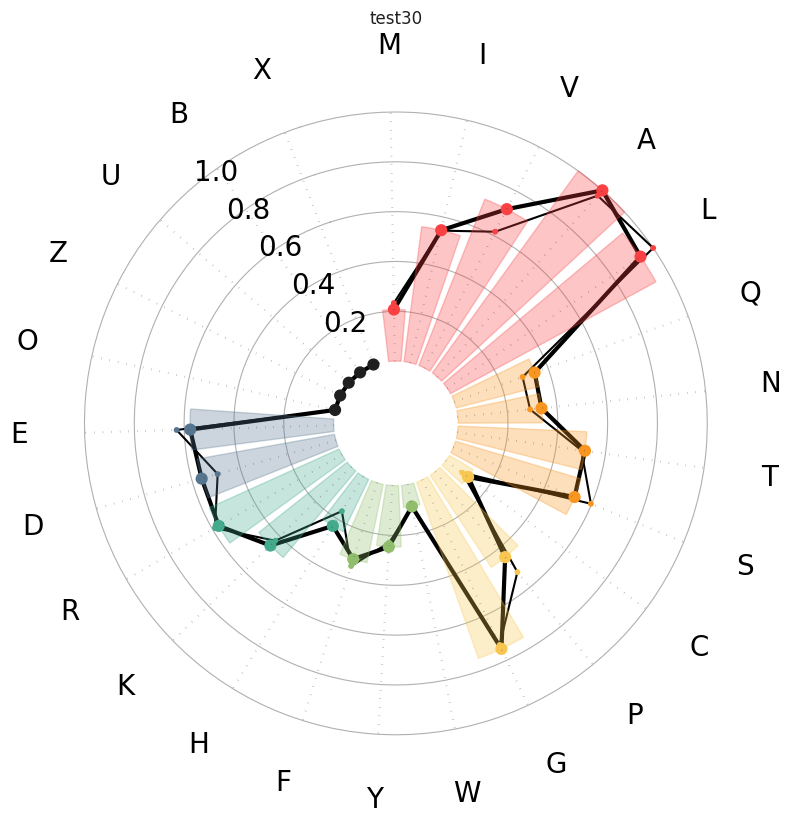

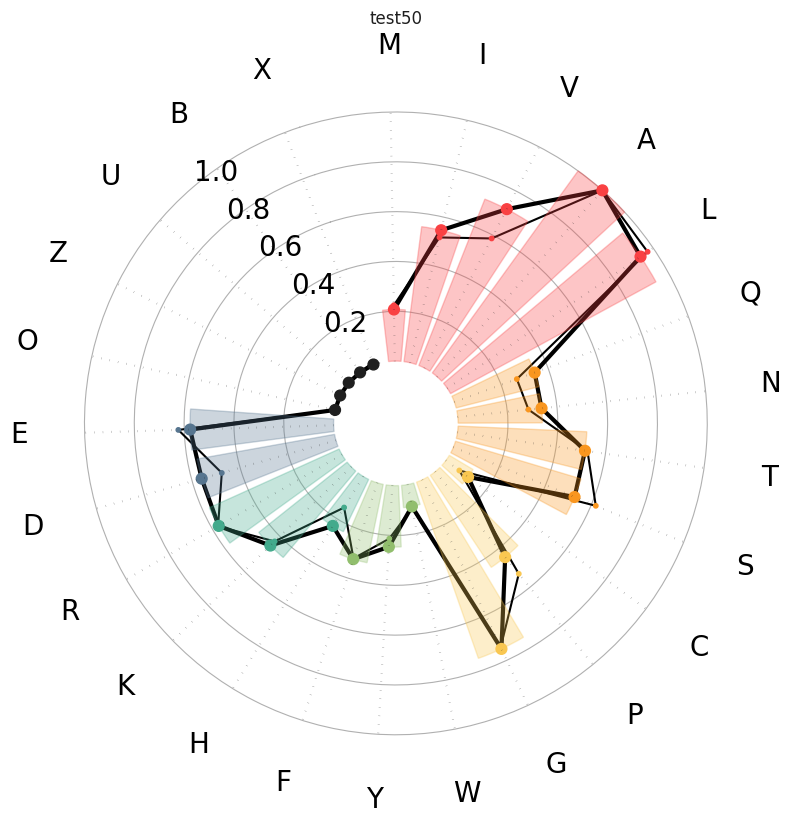

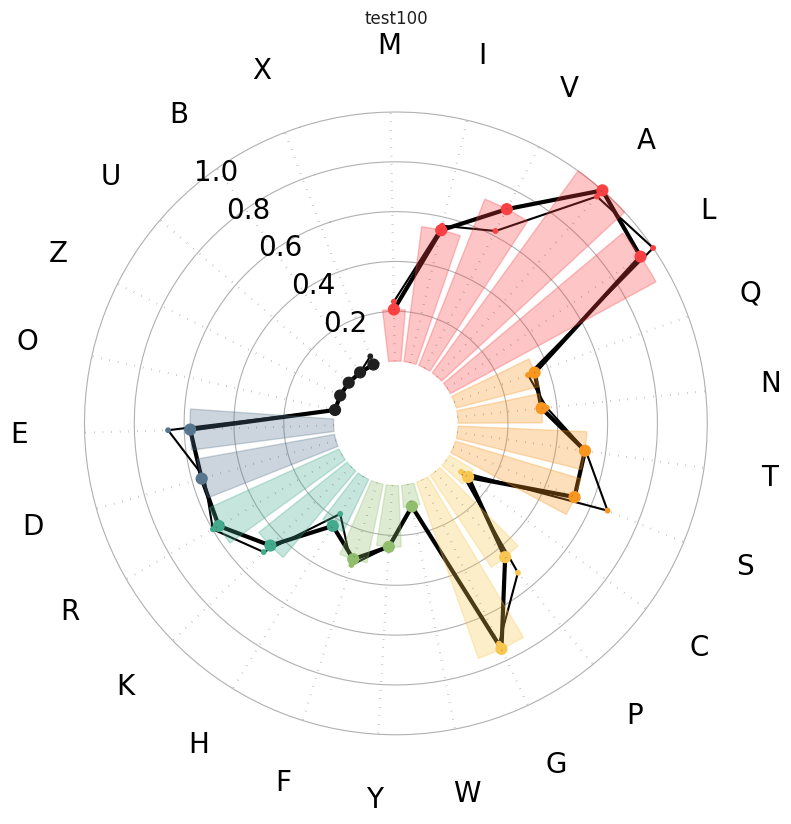

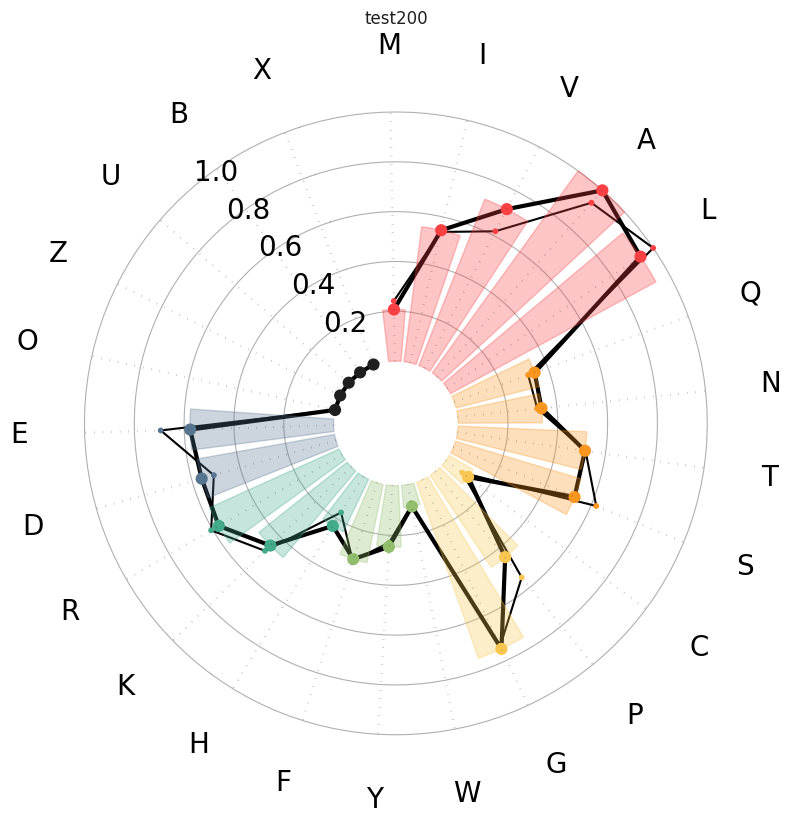

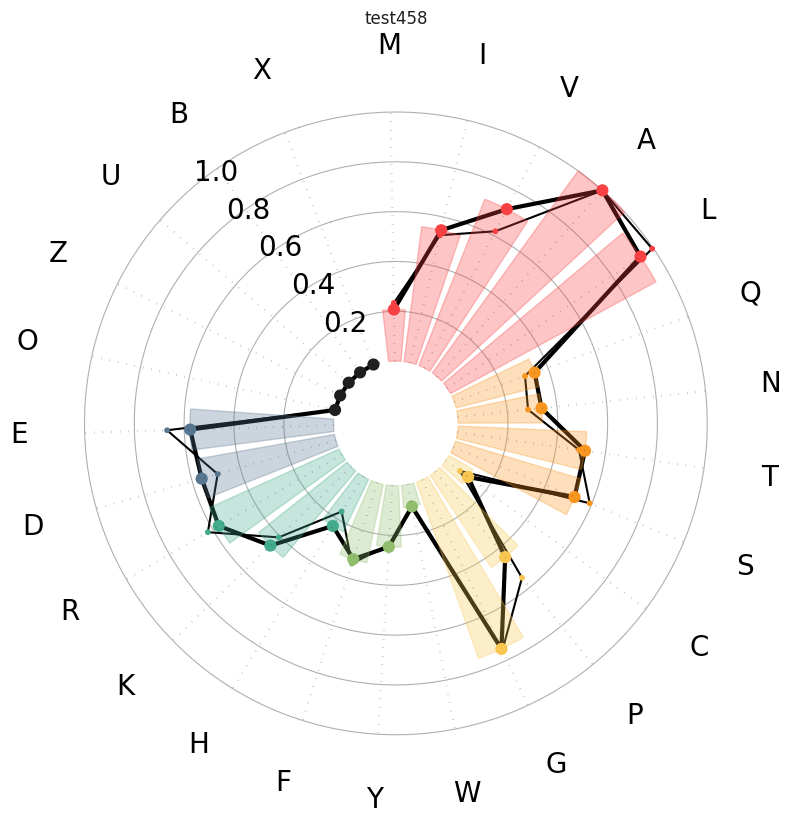

In [31]:
for i in ["test5", "test6", "test7", "test8", "test9", "test10", "test11", "test12", "test13", "test14",
         "test15", "test16", "test17", "test18", "test19", "test20", "test30", "test50", "test100",
          "test200", "test458"]:
    print("Plotting TEST:", i)
    ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sorted), endpoint=False)
    LENGTHS = normalized_df["Ocurrences"].values
    TEST_VALUES = normalized_df[i].values
    MEAN_GAIN = normalized_df["Ocurrences"].values
    REGION = normalized_df["Amino acid"].values
    TRACKS_N = normalized_df["Ocurrences"].values
    COLORS = normalized_df["Color"].values
    GREY12 = "#1f1f1f"
    plt.rcParams.update({"font.family": "Helvetica"})
    plt.rcParams["text.color"] = GREY12
    plt.rc("axes", unicode_minus=False)
    plt.rc('font', weight='regular')

    fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})
    ax.bar(ANGLES, LENGTHS, color=COLORS, edgecolor=COLORS, alpha=0.3, width=0.20, zorder=10)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.set_theta_offset(1.2 * np.pi / 2)
    ax.set_ylim(-0.25, 1.15)
    plt.yticks(fontsize=20)
    ax.plot(ANGLES, LENGTHS, color='black',linewidth=3.0)
    ax.scatter(ANGLES, LENGTHS, s=60, color=COLORS, zorder=11)
    ax.vlines(ANGLES, 0, 1, color=GREY12, ls=(0, (0.1, 4)), zorder=11)
    ax.scatter(ANGLES, TEST_VALUES, s=10, color=COLORS, zorder=11)
    ax.plot(ANGLES, TEST_VALUES, color="black" )#808080
    # Set the labels
    ax.set_xticks(ANGLES)
    ax.set_yticks([0.2,0.4, 0.6, 0.8,1.0])
    ax.set_xticklabels(REGION, size=20);
    ax.xaxis.grid(False)
    ax.spines["polar"].set_color("none")
    ax.set_title(i)
    XTICKS = ax.xaxis.get_major_ticks()
    for tick in XTICKS:
        tick.set_pad(10)
    fig.savefig(f'/agh/projects/noelia/NLP/zymCTRL/1.param_optimization/figs/aa_frequences_{i}.png', format='png', dpi=1200)


#### Computing distances to the natural distribution

In [11]:
b5 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test5"].values))
b6 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test6"].values))
b7 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test7"].values))
b8 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test8"].values))
b9 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test9"].values))
b10 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test10"].values))

b11 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test11"].values))
b12 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test12"].values))
b13 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test13"].values))
b14 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test14"].values))
b15 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test15"].values))
b16 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test16"].values))

b17 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test17"].values))
b18 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test18"].values))
b19 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test19"].values))
b20 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test20"].values))

b30 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test30"].values))
b50 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test50"].values))
b100 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test100"].values))
b200 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test200"].values))
b458 = np.sum(np.abs(normalized_df["Ocurrences"].values - normalized_df["test458"].values))


In [12]:
myvarlist = [ b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b30,b50,b100,b200,b458] # lowest is topk 8

In [27]:
thelist=[]
for index,i in enumerate(myvarlist):
    thelist.append(i)
    print(index, i)

0 0.9837432506551678
1 0.9925332877205293
2 0.9175955313389382
3 0.8790156666233752
4 0.741922631364047
5 0.990182985247632
6 0.8111957724596676
7 1.0518822624663586
8 0.762926973344796
9 1.1842055313791005
10 1.0157630140576426
11 0.8609301932478243
12 0.8895545386095127
13 1.1407840272646677
14 0.8545936651446755
15 0.8765643317734495
16 0.8192347545675416
17 0.8785502231129897
18 0.866051434119196
19 0.88514261607657
20 0.9057249146609898


In [29]:
sorted(thelist)

[0.741922631364047,
 0.762926973344796,
 0.8111957724596676,
 0.8192347545675416,
 0.8545936651446755,
 0.8609301932478243,
 0.866051434119196,
 0.8765643317734495,
 0.8785502231129897,
 0.8790156666233752,
 0.88514261607657,
 0.8895545386095127,
 0.9057249146609898,
 0.9175955313389382,
 0.9837432506551678,
 0.990182985247632,
 0.9925332877205293,
 1.0157630140576426,
 1.0518822624663586,
 1.1407840272646677,
 1.1842055313791005]